In [15]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml

from model.model import get_model
from data_loader import TrainDataModule, get_all_test_dataloaders, get_normal_test_dataloader, get_train_dataloader
from ganomaly_eval import GanomalyEvaluator, EvalType
from torch.utils.data import Dataset, DataLoader

from PIL import Image

# autoreload imported modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Global seed set to 42


Loading model ganomaly


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 128, 128])
./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020478.png
torch.Size([1, 1, 128, 128])
./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020207.png
torch.Size([1, 1, 128, 128])
./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000518.png
torch.Size([1, 1, 128, 128])
./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000465.png


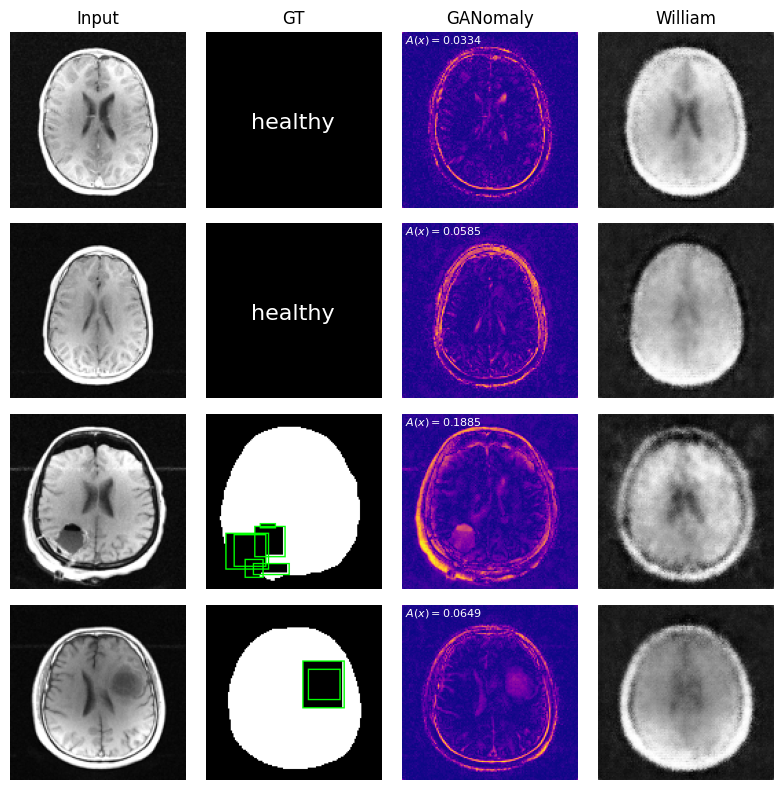

In [16]:
# with open("./configs/ganomaly_config.yaml", "r") as f:
best = (
    "/home/marcel/Projects/uni/mad_seminar/models/proud-shape-47/ganomaly_config.yaml"
)
test = "./configs/ganomaly_config.yaml"
ae_conf = "./configs/ae_config.yaml"
with open(test, "r") as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config["seed"])

# load model from checkpit
from data_loader import PosterDataset, PosterNormalDataset
from model.ganomaly.lightning_model import Ganomaly
import numpy as np
import cv2


model = get_model(config)

# model = Ganomaly(
#     batch_size=256,
#     input_size=(64, 64),
#     latent_vec_size=256,  # 256,
#     wadv=1,
#     wcon=50,
#     wenc=1,
#     # lr=config["lr"],
#     beta1=0.5,
#     beta2=0.999,
# )
# custom_cp = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_1/checkpoints/epoch=149-step=300.ckpt"
# Initialize the model by loading from the checkpoint
best_cp = "/home/marcel/Projects/uni/mad_seminar/models/proud-shape-47/epoch=111-step=5152.ckpt"
ae_cp = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_49/checkpoints/epoch=99-step=2300.ckpt"
test_cp = "lightning_logs/version_54/checkpoints/epoch=119-step=1440.ckpt"
model.load_state_dict(torch.load(test_cp)["state_dict"])
# model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

# normal_test = "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000347.png"

# file_keys = ["file_brain_AXT1_202_6000518.png", "file_brain_AXT1_202_6000518.png"]
# img_base_path = "/home/marcel/Projects/uni/mad_seminar/data/fastMRI/brain_mid_png/"
# pos_base_path = (
#     "/home/marcel/Projects/uni/mad_seminar/data/fastMRI/brain_mid_anno_pos_png/"
# )
# neg_base_path = (
#     "/home/marcel/Projects/uni/mad_seminar/data/fastMRI/brain_mid_anno_neg_png/"
# )
img = [
    "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000518.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020009.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020156.png",
    "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000465.png",
]
pos = [
    "/home/marcel/Projects/uni/mad_seminar/data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_6000518_craniotomy_1.png",
    # "data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_2020009_resection_cavity_2.png",
    # "data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_2020156_resection_cavity_3.png",
    "data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_6000465_edema_0.png",
]
neg = [
    "/home/marcel/Projects/uni/mad_seminar/data/fastMRI/brain_mid_anno_neg_png/file_brain_AXT1_202_6000518.png",
    # "data/fastMRI/brain_mid_anno_neg_png/file_brain_AXT1_202_2020009.png",
    # "data/fastMRI/brain_mid_anno_neg_png/file_brain_AXT1_202_2020156.png",
    "data/fastMRI/brain_mid_anno_neg_png/file_brain_AXT1_202_6000465.png",
]

img_bbox = {
    "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000518.png": [
        "data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_6000518_resection_cavity_5.png",
        "data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_6000518_posttreatment_change_2.png",
        "data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_6000518_craniotomy_1.png",
        "data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_6000518_resection_cavity_4.png",
        "data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_6000518_posttreatment_change_3.png",
        "data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_6000518_craniotomy_0.png",
    ],
    "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000465.png": [
        "data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_6000465_edema_0.png",
        "data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_6000465_mass_1.png",
    ],
}

poster_dl = DataLoader(
    PosterDataset(
        target_size=(128, 128),
        # img_paths=[img_base_path + f for f in file_keys],
        # pos_mask_paths=[pos_base_path + f for f in file_keys],
        # neg_mask_paths=[neg_base_path + f for f in file_keys],
        img_paths=img,
        pos_mask_paths=pos,
        neg_mask_paths=neg,
    ),
    batch_size=1,
)


normal_imgs = [
    # train
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020543.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020319.png",
    "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020478.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_201_6002861.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020323.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020175.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020033.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020102.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_201_6002816.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000349.png",
    # test
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_201_6002834.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000451.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020038.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020521.png",
    "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020207.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020563.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000591.png",
    # "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020019.png",
]
poster_normal_dl = DataLoader(
    PosterNormalDataset(
        target_size=(128, 128),
        img_paths=normal_imgs,
    ),
    batch_size=1,
)

data = []

for batch in poster_normal_dl:
    img, idx = batch
    print(img.shape)
    print(poster_normal_dl.dataset.img_paths[idx])
    out = model.detect_anomaly(img)  # dict of rec, anoamly maps, anomaly score

    # img = img.squeeze().detach().cpu().numpy()
    rec = out["reconstruction"].squeeze()  # .detach().cpu().numpy()
    out["img"] = img
    out["anomaly_map"] = np.abs(img - rec)
    out["gt"] = np.ones((128, 128))
    out["reconstruction"] = rec
    data.append(out)

for batch in poster_dl:
    img, pos_mask, neg_mask, idx = batch
    print(img.shape)
    print(poster_dl.dataset.img_paths[idx])
    out = model.detect_anomaly(img)  # dict of rec, anoamly maps, anomaly score

    # img = img.squeeze().detach().cpu().numpy()
    rec = out["reconstruction"].squeeze()  # .detach().cpu().numpy()
    out["img"] = img
    # out["pos_mask"] = pos_mask
    # out["neg_mask"] = neg_mask
    out["reconstruction"] = rec
    out["anomaly_map"] = np.abs(img - rec)

    # bbox calculation
    # mask_i = pos_mask.detach().cpu().numpy().squeeze()
    neg_mask_i = neg_mask.detach().cpu().numpy().squeeze()
    bboxes = cv2.cvtColor(neg_mask_i * 255, cv2.COLOR_GRAY2RGB)
    for path in img_bbox[poster_dl.dataset.img_paths[idx]]:
        img = Image.open(path).convert("L")
        img = img.resize((128, 128), Image.BICUBIC)
        img = np.array(img).squeeze()
        cnts_gt = cv2.findContours(
            (img * 255).astype(np.uint8),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE,
        )
        cnts_gt = cnts_gt[0] if len(cnts_gt) == 2 else cnts_gt[1]
        gt_box = []

        for c_gt in cnts_gt:
            x, y, w, h = cv2.boundingRect(c_gt)
            gt_box.append([x, y, x + w, y + h])

            cv2.rectangle(bboxes, (x, y), (x + w, y + h), (0, 255, 0), 1)
            # # Add text to describe the rectangle
            # text = f"Rectangle"
            # font = cv2.FONT_HERSHEY_SIMPLEX
            # font_scale = 0.1
            # font_thickness = 1
            # text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
            # text_x = x + 5
            # text_y = y + text_size[1] + 5
            # color = 1
            # cv2.putText(bboxes, text, (text_x, text_y), font, font_scale, color, font_thickness)

    out["gt"] = bboxes
    data.append(out)

fig, ax = plt.subplots(len(data), 4, figsize=(8, 8))

for i, d in enumerate(data):
    if i == 0:
        ax[i, 0].set_title("Input")
        ax[i, 1].set_title("GT")
        # ax[i, 2].set_title("Neg mask")
        # ax[i, 3].set_title("Reconstruction")
        ax[i, 2].set_title("GANomaly")
        ax[i, 3].set_title("William")
    ax[i, 0].imshow(d["img"].squeeze(), cmap="gray")
    ax[i, 1].imshow(d["gt"].squeeze(), cmap="gray")
    if i < 2:
        ax[i, 1].text(32, 70, "healthy", color="white", fontsize=16)
    # ax[i, 2].imshow(d["neg_mask"].squeeze(), cmap="gray")
    # ax[i, 3].imshow(d["reconstruction"].squeeze(), cmap="gray")
    ax[i, 2].imshow(d["anomaly_map"].squeeze(), cmap="plasma")
    ax[i, 2].text(
        2, 8, f"$A(x) = {d['anomaly_score'].item():.4f} $", color="white", fontsize=8
    )
    # ax[i, 3].imshow(np.random.rand(128, 128), cmap="plasma")
    ax[i, 3].imshow(d["reconstruction"], cmap="gray")

    # add williams

    for ax_ in ax[i]:
        ax_.axis("off")

plt.tight_layout()
plt.savefig("qualitative.png", dpi=500)
plt.show()

In [17]:
# import cv2


# for d in poster_dl:
#     img, pos_mask, neg_mask = d
#     mask_i = pos_mask.detach().cpu().numpy().squeeze()
#     neg_mask_i = neg_mask.detach().cpu().numpy().squeeze()
#     bboxes = cv2.cvtColor(neg_mask_i * 255, cv2.COLOR_GRAY2RGB)
#     cnts_gt = cv2.findContours(
#         (mask_i * 255).astype(np.uint8),
#         cv2.RETR_EXTERNAL,
#         cv2.CHAIN_APPROX_SIMPLE,
#     )
#     cnts_gt = cnts_gt[0] if len(cnts_gt) == 2 else cnts_gt[1]
#     gt_box = []

#     for c_gt in cnts_gt:
#         x, y, w, h = cv2.boundingRect(c_gt)
#         gt_box.append([x, y, x + w, y + h])
#         cv2.rectangle(bboxes, (x, y), (x + w, y + h), (0, 255, 0), 1)
        
#     # plt.imshow(bboxes, cmap="gray")
#     # print(bboxes.shape)